# Ressources

In [19]:
import pandas as pd
import numpy as np
import missingno

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pycaret.classification import *

# fix pour plotly express et Visual Studio Code
import plotly.io as pio
pio.renderers.default = "notebook_connected"

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer


from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import StandardScaler



# Garbage collection is to release memory when the object is no longer in use. This system destroys the unused object and reuses its memory slot for new objects. You can imagine this as a recycling system in computers.

import shap


from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold

from rich.console import Console

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# A lire : 

# https://jules-stacy.github.io/projects/hotel-logistic-python/
# https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
# https://www.kaggle.com/code/mlisovyi/modular-good-fun-with-ligthgbm/comments + https://www.kaggle.com/code/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761
# https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html

#

# Matrice de confusion + SMOTE sur totalité du dataset ?

# https://www.kaggle.com/code/tini9911/imbalance-in-data
# https://www.kaggle.com/code/deepak2873/credit-bureau-imbalance-classification

# à voir

# https://www.kaggle.com/code/shailaja4247/tackle-any-credit-risk-analysis-problem-homecredit

# Question 1: I don't agree that we should combine the training and testing and then apply normalization or imputation. We should split the data, normalize the training set and apply what we have learned from training dataset on the testing dataset. Similarly, for imputation - we learn on the training and transform what we have learned on the dataset.
# Regarding your question about the imputation, you will notice that we often have three main methods while imputing the data in most of the libraries; fit_transform(), fit(), and transform(). Usually, you apply fit_transform() or fit() then transform() on the training data. Then, transform() is applied to the testing dataset. This is because you want to have a fair evaluation of the model. You transform what you have learned from training data. If you fit imputation on both training and testing, then any new testing dataset requires you to re-impute all data again, and this allows leaking information/feature into the model because the information from testing dataset is included in training the model, and consequently, your model won't be able to predict a new data. To this end, you apply the transform of imputation that has already fitted on the training dataset on the new/testing dataset as pre-processing and fairly test how the model can predict a new fresh dataset.

# Overall, make sure to calculate your metric (e.g. median, mean,.. ) only on the train data in order to avoid data leakage to your test data-set while imputing your data-set.


# Fonctions
## Data

In [20]:
def comparaisons_colonnes(df1:pd.DataFrame, df2:pd.DataFrame):
    """Compare les colonnes de deux DF, et renvoient celles qui ne sont pas présentes dans les deux fichiers.

    Parameters
    -----------
    df1: :class:`DataFrame`

    df2: :class:`DataFrame`

            
    Return
    ----------
    Deux listes avec la différence dans le DataFrame 1 puis le DataFrame 2
    
    Exemples
    ----------
    list_1 = list(df_2015.columns)
    
    list_2 = list(df_2016.columns)

    dif1, dif2 = comparaisons_colonnes(df1, df2)
    """
    
    list_1 = list(df1.columns)
    list_2 = list(df2.columns)
    # Un set est un ensemble de clefs non ordonnées et non redondant où l'on peut savoir
    # si un élément est présent sans avoir à parcourir toute la liste (une sorte de dictionnaire où les valeurs seraient ignorées, seules les clefs comptent).
    dif_list_1_list_2 = list(set(list_1) - set(list_2))
    dif_list_2_list_1 = list(set(list_2) - set(list_1))
    nb_dif_list1_list_2 = len(dif_list_1_list_2)
    nb_dif_list2_list1 = len(dif_list_2_list_1)
    print(f'Colonnes présentes dans le df1, absentes dans le df2 ({nb_dif_list1_list_2}) : {dif_list_1_list_2}')
    print(f'Colonnes présentes dans le df2, absentes dans le df1 ({nb_dif_list2_list1}) : {dif_list_2_list_1}')
    

    
def identification_colonne_binaire(df, var_ignore=None):
    
    df_identif = df.copy()
    if var_ignore != None:
        df_identif.drop([var_ignore], axis=1, inplace=True)
    nb_cols = df_identif.shape[1]
    col_binaire_name = []
    col_binaire_number = []
    for i in range(0, nb_cols):
        len_colonne = len(df_identif.iloc[:,i].value_counts())
        
        if len_colonne == 2:
            col_binaire_name.append(df_identif.iloc[:,i].name)
            col_binaire_number.append(i)
            
            
            
    print(f'Colonnes binaires : {col_binaire_name}')
    print(f'Nombres : {len(col_binaire_number)}')
    
    return col_binaire_name, col_binaire_number


def identification_colonne_categorique(df, var_ignore=None, nb_valeurs_unique=2):
    
    df_identif = df.copy()
    if var_ignore != None:
        df_identif.drop([var_ignore], axis=1, inplace=True)
    nb_cols = df_identif.shape[1]
    col_binaire_name = []
    col_binaire_number = []
    for i in range(0, nb_cols):
        len_colonne = len(df_identif.iloc[:,i].value_counts())
        
        if nb_valeurs_unique == 2:
            if len_colonne == nb_valeurs_unique:
                col_binaire_name.append(df_identif.iloc[:,i].name)
                col_binaire_number.append(i)
                df_identif.iloc[:,i] = df_identif.iloc[:,i].astype('object')
        else:
            if len_colonne <= nb_valeurs_unique:
                col_binaire_name.append(df_identif.iloc[:,i].name)
                col_binaire_number.append(i)
                df_identif.iloc[:,i] = df_identif.iloc[:,i].astype('object')
            
            
    if var_ignore != None:
        df_identif[var_ignore] = df[var_ignore]
            
            
            
    print(f'Colonnes binaires : {col_binaire_name}')
    print(f'Nombres : {len(col_binaire_number)}')
    
    return df_identif


def distribution_target(train_df_test):
    distrib_target = train_df_test['TARGET'].value_counts()  / len(train_df_test['TARGET'])*100


    # fig = px.histogram(train_df_test, x="TARGET", color="TARGET", text_auto=True)

    # fig.show()

    fig = make_subplots(rows=1, cols=2, subplot_titles=("Distribution", "Répartition"),
                            specs=[[{"type": "xy"}, {"type": "domain"}]])

    cat0 = train_df_test[train_df_test['TARGET']==0]['TARGET']
    cat1 = train_df_test[train_df_test['TARGET']==1]['TARGET']

    # fig.add_trace(go.Histogram(x=train_df_test['TARGET']), row=1, col=1)
    fig.add_trace(go.Histogram(x=cat0, name="0", text=str(cat0.count())), row=1, col=1)
    fig.add_trace(go.Histogram(x=cat1, name="1", text=str(cat1.count())), row=1, col=1)
    fig.add_trace(go.Pie(values=distrib_target.values), row=1, col=2)


    fig.update_layout(height=500, showlegend=False, title_text="TARGET")

    #x axis    
    fig.update_xaxes(visible=False)

    fig.show()

### Corrélation

In [21]:
def correlation_independante_et_dependante(df:pd.DataFrame, colonne:str, title:str):
        
        """Corrélation entre des variables indépendantes avec une variable dépendante.
        Renvoie une heatmap en une seule colonne

    Parameters
    -----------
    df: :class:`DataFrame`
            Le DataFrame
    colonne: :class:`str`
            La variable dépendante, où on va juger les corrélations des autres variables
    title: :class:`str`
            Titre du graphique
            
    Return
    ----------
    Graphique
    """
        
        f, ax = plt.subplots(figsize=(11, 20))

        heatmap = sns.heatmap(df.corr()[[colonne]].sort_values(by=colonne, ascending=False), annot=True)
        
        heatmap.set_title(title, fontdict={'fontsize':18}, pad=16);

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
        

from rich.console import Console

def lightbgm(train_df, test_df, num_folds=10, stratified=False):
    console = Console()
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0]) # créer une array remplie de 0 qui aura les mêmes dimensions que le df
    sub_preds = np.zeros(test_df.shape[0]) # créer une array remplie de 0 qui aura les mêmes dimensions que le df
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']] # variables du DF qui ne sont pas dans la liste (Target est la variable à prédire, les autres n'ont pas d'impact sur la prédiction)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            # nthread=8,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            device="cpu",
            n_jobs=-1)

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        # predit proba est utilisé pour prédire les possibilités de classe.
        # predit proba = % que la proba soit égale à 1 car [:,1]. Si on ne met rien, on a la proba pour 0 et 1.
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits # Retourne la probabilité prédite pour chaque classe pour chaque échantillon. Division pour faire la moyenne entre les folds

        
        # console.print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])), style="green")
        
    console.print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds), style="green")
        
        
    test_df['TARGET'] = sub_preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_kevin.csv', index= False)
    
    return clf, train_df, test_df, feats

### AUC

In [23]:
from imblearn.pipeline import Pipeline, make_pipeline
# def auc_smoke(df, model, cv=None):
#     """
#     Creates folds manually, and upsamples within each fold.
#     Returns an array of validation (recall) scores
#     """
#     if cv is None:
#         cv = KFold(n_splits=5, random_state=42, shuffle=True)
        
#     X = df.drop(['TARGET'], axis=1)
#     y = df['TARGET']   
        
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

#     smoter = SMOTE(random_state=42)
    
#     scores = []

#     for train_fold_index, val_fold_index in cv.split(X_train, y_train):
#         # Get the training data
#         X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train[train_fold_index]
#         # Get the validation data
#         X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train[val_fold_index]

#         # Upsample only the data in the training section
#         X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
#                                                                            y_train_fold)
#         # Fit the model on the upsampled training data
#         model_obj = model.fit(X_train_fold_upsample, y_train_fold_upsample)
#         # Score the model on the (non-upsampled) validation data
#         score = roc_auc_score(y_val_fold, model_obj.predict_proba(X_val_fold)[:, 1])
#         scores.append(score)
#     return np.array(scores)

      
def auc_smoke(df, model, impute="SimpleImputer", cv=None):
    # https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
    
    if cv is None:
        kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
        # kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
        
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']
    
    # using the median is OK if your distribution is not normal, because the median is not influenced by the outliers. 
    # If your distribution is close to normal, you may use mean as a better representative.
    
    
    if impute == "SimpleImputer":   
        imp = SimpleImputer(missing_values = np.nan, strategy="median")
        
    
    elif impute == "Iterative":
        imp = IterativeImputer(missing_values = np.nan, random_state=0)
        

    imb = make_pipeline(imp, StandardScaler(), SMOTE(random_state=42), model)
    

    score = cross_val_score(imb, X, y, scoring="roc_auc", cv=kf, n_jobs=-1)


    print(f"Cross val score (avg) : {score.mean()}")
    
    
    
def auc_smoke_split(df, model, impute="SimpleImputer"):
    
    # https://vch98.medium.com/preventing-data-leakage-standardscaler-and-smote-e7416c63259c
    
    kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # kf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']
    
    if impute == "SimpleImputer":   
        imp = SimpleImputer(missing_values = np.nan, strategy="median")
        
    
    elif impute == "Iterative":
        imp = IterativeImputer(missing_values = np.nan, random_state=0)
        
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    
    pipe = make_pipeline(imp, StandardScaler(), SMOTE(random_state=42), model)
    
    pipe.fit(X_train, y_train)
    
    score = cross_val_score(pipe, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1)
    
    print(f"Cross val score (avg) : {score.mean()}")
    
    
def auc_smoke_split_test(df, model, impute="SimpleImputer"):
    
    # https://vch98.medium.com/preventing-data-leakage-standardscaler-and-smote-e7416c63259c
    
    kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # kf = KFold(n_splits=5, random_state=42, shuffle=True)
   
    if impute == "SimpleImputer":   
        imp = SimpleImputer(missing_values = np.nan, strategy="median")
        
    
    elif impute == "Iterative":
        imp = IterativeImputer(missing_values = np.nan, random_state=0)
        
    sm = SMOTE(random_state=42)
    
    ss = StandardScaler()    
        
                      
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    
    columns = X.columns
    
    X_train = pd.DataFrame(imp.fit_transform(X_train[columns]), columns=columns)
    
    X_train = pd.DataFrame(ss.fit_transform(X_train[columns]), columns=columns)
    
    X_test = pd.DataFrame(imp.transform(X_test[columns]), columns=columns)
    
    X_test = pd.DataFrame(ss.transform(X_test[columns]), columns=columns)

    
    X_train, y_train = sm.fit_resample(X_train, y_train)
    
    
    pred_test_y, pipefit, conf_mat, class_rpt =  evaluate_result(model, X_train, y_train, X_test, y_test, param_flg='N')
    

def auc_smoke_split_smoke_entire(df, model, impute="SimpleImputer"):
    
    # https://www.kaggle.com/code/deepak2873/credit-bureau-imbalance-classification?scriptVersionId=5253968&cellId=140
    
    kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # kf = KFold(n_splits=5, random_state=42, shuffle=True)
   
    if impute == "SimpleImputer":   
        imp = SimpleImputer(missing_values = np.nan, strategy="median")
        
    
    elif impute == "Iterative":
        imp = IterativeImputer(missing_values = np.nan, random_state=0)
        
    sm = SMOTE(random_state=42)
    ss = StandardScaler()    
        
                      
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']
    
    columns = X.columns
    
    X = pd.DataFrame(imp.fit_transform(X[columns]), columns=columns)
    
    X = pd.DataFrame(ss.fit_transform(X[columns]), columns=columns)
    
    X, y = sm.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
       
    
    pred_test_y, pipefit, conf_mat, class_rpt =  evaluate_result(model, X_train, y_train, X_test, y_test, param_flg='N')
    
    
def auc_smoke_test(df, model, impute="SimpleImputer"):
    
    # https://vch98.medium.com/preventing-data-leakage-standardscaler-and-smote-e7416c63259c
    
    kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # kf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']
    
    if impute == "SimpleImputer":   
        imp = SimpleImputer(missing_values = np.nan, strategy="median")
        
    
    elif impute == "Iterative":
        imp = IterativeImputer(missing_values = np.nan, random_state=0)
        
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    
    pipe = make_pipeline(imp, StandardScaler(), SMOTE(random_state=42), model)
    
    # pipe.fit(X_train, y_train)
    
    # score = cross_val_score(pipe, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1)
    
    # print(f"Total : {score.mean()}")
    
    pred_test_y, pipefit, conf_mat, class_rpt = evaluate_result(pipe, X_train, y_train, X_test, y_test, param_flg='N')
    

def auc_smoke_test_with_balanced(df, model, impute="SimpleImputer"):
    
    # https://vch98.medium.com/preventing-data-leakage-standardscaler-and-smote-e7416c63259c
    
    kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # kf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']
    
    if impute == "SimpleImputer":   
        imp = SimpleImputer(missing_values = np.nan, strategy="median")
        
    
    elif impute == "Iterative":
        imp = IterativeImputer(missing_values = np.nan, random_state=0)
        
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    
    pipe = make_pipeline(imp, StandardScaler(), model)
    
    # pipe.fit(X_train, y_train)
    
    # score = cross_val_score(pipe, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1)
    
    # print(f"Total : {score.mean()}")
    
    pred_test_y, pipefit, conf_mat, class_rpt = evaluate_result(pipe, X_train, y_train, X_test, y_test, param_flg='N')
    

   
    
    
    

def auc_smoke_best_params(df, model, params, cv=None):
    # https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
    if cv is None:
        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']   
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    new_params = {'lgbmclassifier__' + key: params[key] for key in params} # à modifier par le nom du model
    
    imp = IterativeImputer(missing_values = np.nan, random_state=0)
    
    imb = make_pipeline(imp, StandardScaler(), SMOTE(random_state=42), model)
    
    grid_imb = GridSearchCV(imb, param_grid=new_params, cv=kf, scoring="roc_auc", verbose=1, n_jobs=-1)
    
    grid_imb.fit(X_train, y_train)
    
    print(grid_imb.best_score_)
    print(grid_imb.best_params_)
    
    auc_test = roc_auc_score(y_test, grid_imb.predict_proba(X_test)[:,1])
    
    print(auc_test)
    
    return grid_imb
    
    
def auc_smoke_best_params_imp(df, model, params, cv=None):
    # https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
    if cv is None:
        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']   
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    imp = IterativeImputer(missing_values = np.nan, random_state=0)
    
    new_params = {'lgbmclassifier__' + key: params[key] for key in params} # à modifier par le nom du model
    
    imb = make_pipeline(imp, StandardScaler(), SMOTE(random_state=42), model)
    
    grid_imb = GridSearchCV(imb, param_grid=new_params, cv=kf, scoring="roc_auc", verbose=1, n_jobs=-1)
    
    grid_imb.fit(X_train, y_train)
    
    print(grid_imb.best_score_)
    print(grid_imb.best_params_)
    
    auc_test = roc_auc_score(y_test, grid_imb.predict_proba(X_test)[:,1])
    
    print(auc_test)
    
    pred_test_y, pipefit, conf_mat, class_rpt = evaluate_result(grid_imb, X_train, y_train, X_test, y_test, 'N', 'N')
    
    return grid_imb


def auc_smoke_best_params_balanced(df, model, params, cv=None):
    # https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
    if cv is None:
        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']   
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    imp = IterativeImputer(missing_values = np.nan, random_state=0)
    
    new_params = {'lgbmclassifier__' + key: params[key] for key in params} # à modifier par le nom du model
    
    imb = make_pipeline(imp, StandardScaler() , model)
    
    grid_imb = GridSearchCV(imb, param_grid=new_params, cv=kf, scoring="roc_auc", verbose=1, n_jobs=-1)
    
    grid_imb.fit(X_train, y_train)
    
    print(grid_imb.best_score_)
    print(grid_imb.best_params_)
    
    auc_test = roc_auc_score(y_test, grid_imb.predict_proba(X_test)[:,1])
    
    print(auc_test)
    
    pred_test_y, pipefit, conf_mat, class_rpt = evaluate_result(grid_imb, X_train, y_train, X_test, y_test, 'N', 'N')
    
    return grid_imb
    




### Evaluation

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def conf_matrix(conf_mat):
    LABELS = ['0', '1']
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    
def roc_plot(pred_y, test_y):
    ##Computing false and true positive rates
    fpr, tpr, thresholds= roc_curve(pred_y,test_y,drop_intermediate=False)
    
    print( "\n AUC and ROC curve : " )
    plt.figure()
    
    ##Adding the ROC
    plt.plot(fpr, tpr, color='red',    lw=2, label='ROC curve')
    
    ##Random FPR and TPR
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    
    ##Title and label
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    return

def precision_recall_plot(pred_y, test_y):
    
    precision, recall, thresholds = precision_recall_curve( test_y, pred_y)
    
    print(" precision   : ", precision )
    print(" recall      : ", recall )
    print(" thresholds  : ", thresholds )
    
    plt.step(recall, precision, color='b', alpha=0.2,  where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,  color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format( average_precision_score(test_y, pred_y)))
    return

In [25]:
import gc

from sklearn.metrics import confusion_matrix, classification_report

def evaluate_result(clf, X_train, y_train, X_test, y_test, param_flg, fit = 'Y' ) :
    
    # https://www.kaggle.com/code/deepak2873/credit-bureau-imbalance-classification?scriptVersionId=5253968&cellId=114
    # https://www.kaggle.com/code/deepak2873/credit-bureau-imbalance-classification?scriptVersionId=5253968&cellId=135
    #print( 'Fitting the training set' ) 
    if fit == "Y":
        clf.fit(X_train, y_train)
    if  param_flg == 'Y':     print (clf.best_params_ )
 
    # Predict on training set
    #print( 'Predicting the training set' )
    pred_train_y = clf.predict(X_train)
    pred_prob_train = clf.predict_proba(X_train)[:, 1]
      
    # Predict on testing set
    pred_test_y = clf.predict(X_test)
    pred_prob_test = clf.predict_proba(X_test)[:, 1]
    
    # Is our model still predicting just one class? it shouldhave all classes say [0,1]
    print( "\n PREDICTING TARGET CLASS [train data]  : " , np.unique( pred_train_y ))
    print( "\n PREDICTING TARGET CLASS [test data ]  : " , np.unique( pred_test_y ) )
    print("\n" )
    
    # How's our accuracy?
    print(" 1. ACCURACY SCORE [train data]           : ", accuracy_score(y_train, pred_train_y) )
    print(" 2. ACCURACY SCORE [test data ]           : ", accuracy_score(y_test, pred_test_y) )
    
    # How's our ROC score?
    # print(" 3. ROC-AUC SCORE  [test data ]           :  ", roc_auc_score(y_test, pred_test_y) )
    print(" 4. ROC-AUC SCORE  [train data ] (predict_proba)          :  ", roc_auc_score(y_train, pred_prob_train) )
    print(" 5. ROC-AUC SCORE  [test data ] (predict_proba)          :  ", roc_auc_score(y_test, pred_prob_test) )

    # How's actual vs prediction classification?
    conf_mat = confusion_matrix(y_test, pred_test_y)
    class_rpt = classification_report(y_test, pred_test_y)
    
    conf_matrix(conf_mat)
    roc_plot(pred_test_y, y_test)
    precision_recall_plot(pred_test_y, y_test)
    
    del pred_train_y, X_train, y_train, X_test, y_test
    gc.collect()
    

    
    return  pred_test_y, clf, conf_mat, class_rpt

# Classifier

In [26]:
clf = LGBMClassifier(
            # nthread=8,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            device="cpu",
            n_jobs=-1)


clf_balanced = LGBMClassifier(
            # nthread=8,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            device="cpu",
            n_jobs=-1,
            class_weight="balanced")

# Data formatée

In [27]:
# fichier application_test avec uniquement l'id et Target

data_test_clean = pd.read_csv('submission_kernel02.csv')
data_test_clean.rename(columns={'TARGET' : 'PROBA_TARGET'}, inplace=True)
data_test_clean

# Target = La probabilité prédite pour chaque classe pour chaque échantillon. Pourquoi dans un dataset séparé ?

,SK_ID_CURR,PROBA_TARGET
0,100001,0.034300
1,100005,0.146855
2,100013,0.027505
3,100028,0.038554
4,100038,0.153569
...,...,...
48739,456221,0.046247
48740,456222,0.060781
48741,456223,0.008308
48742,456224,0.026186


In [28]:
# Fichier application_train fusionnée
data_results = pd.read_csv('data_featured.csv')


In [29]:
data_results

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356247,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356248,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356249,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Selection des features -> Imputer -> Smote

In [30]:
df_importance = pd.read_csv('feature_importance_avg.csv')
df_importance

,feature,importance,importance_normalized,cumulative_importance
0,PAYMENT_RATE,1128.6,0.071755,0.071755
1,EXT_SOURCE_1,1005.5,0.063928,0.135683
2,EXT_SOURCE_3,960.6,0.061073,0.196756
3,EXT_SOURCE_2,913.9,0.058104,0.254861
4,DAYS_BIRTH,718.4,0.045675,0.300535
5,AMT_ANNUITY,537.4,0.034167,0.334702
6,DAYS_EMPLOYED,510.9,0.032482,0.367185
7,APPROVED_CNT_PAYMENT_MEAN,432.5,0.027498,0.394682
8,DAYS_ID_PUBLISH,431.5,0.027434,0.422116
9,INCOME_CREDIT_PERC,415.3,0.026404,0.448521


# Selection features

On va selectionner selon le feature importance

In [31]:
cols = df_importance.sort_values(by=["importance"], ascending=False)['feature'].unique()[:20]
data_features = data_results[cols]

data_features['SK_ID_CURR'] = data_results['SK_ID_CURR']
data_features['TARGET'] = data_results['TARGET']

data_features

# ---------------

# from sklearn.feature_selection import SelectFromModel

# selector = SelectFromModel(LGBMClassifier(random_state=42), max_features=20).fit(data_results.drop("TARGET", axis=1), data_results['TARGET'])
# columns = selector.get_feature_names_out().tolist()
# display(f"Colonnes retenues : {columns}")

# columns.append('TARGET')

# data_features = data_results[columns]

,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,APPROVED_CNT_PAYMENT_MEAN,DAYS_ID_PUBLISH,INCOME_CREDIT_PERC,...,INSTAL_DPD_MEAN,DAYS_REGISTRATION,DAYS_EMPLOYED_PERC,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,AMT_CREDIT,PREV_CNT_PAYMENT_MEAN,AMT_GOODS_PRICE,INSTAL_AMT_PAYMENT_SUM,SK_ID_CURR,TARGET
0,0.060749,0.083037,0.139376,0.262949,9461,24700.5,-637.0,24.000000,-2120,0.121978,...,0.000000,-3648.0,0.067329,780.0,406597.5,24.000000,351000.0,219625.695,100002,1.0
1,0.027598,0.311267,NaN,0.622246,16765,35698.5,-1188.0,10.000000,-291,0.132217,...,0.000000,-1186.0,0.070862,1216.0,1293502.5,10.000000,1129500.0,1618864.650,100003,0.0
2,0.050000,NaN,0.729567,0.555912,19046,6750.0,-225.0,4.000000,-2531,0.100000,...,0.000000,-4260.0,0.011814,NaN,135000.0,4.000000,135000.0,21288.465,100004,0.0
3,0.094941,NaN,NaN,0.650442,19005,29686.5,-3039.0,18.000000,-2437,0.219900,...,0.000000,-9833.0,0.159905,NaN,312682.5,23.000000,297000.0,1007153.415,100006,0.0
4,0.042623,NaN,NaN,0.322738,19932,21865.5,-3038.0,20.666667,-3458,0.179963,...,0.954545,-4311.0,0.152418,NaN,513000.0,20.666667,513000.0,806127.975,100007,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,0.042354,NaN,0.643026,0.648575,19970,17473.5,-5169.0,24.000000,-3399,0.143815,...,0.000000,-9094.0,0.258838,495.0,412560.0,24.000000,270000.0,273109.365,456221,NaN
356247,0.051267,NaN,NaN,0.684596,11186,31909.5,-1149.0,17.500000,-3003,0.202600,...,0.520548,-3015.0,0.102718,NaN,622413.0,17.500000,495000.0,567315.675,456222,NaN
356248,0.105414,0.733503,0.283712,0.632770,15922,33205.5,-3037.0,11.000000,-1504,0.163978,...,0.000000,-2681.0,0.190742,NaN,315000.0,11.000000,315000.0,185271.930,456223,NaN
356249,0.055840,0.373090,0.595456,0.445701,13968,25128.0,-2731.0,17.000000,-1364,0.111680,...,0.034483,-1461.0,0.195518,-2.0,450000.0,14.500000,450000.0,500807.790,456224,NaN


In [32]:
data_features_train = data_features[data_features['TARGET'].notnull()] # Target présent
data_features_train.drop(['SK_ID_CURR'], axis=1, inplace=True)
data_features_test = data_features[data_features['TARGET'].isnull()] # Target NA

print(f"Train : {data_features_train.shape}")
print(f"Test : {data_features_test.shape}")

feat = feat = [f for f in data_features_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']] # variables du DF qui ne sont pas dans la liste (Target est la variable à prédire, les autres n'ont pas d'impact sur la prédiction)

Train : (307507, 21)
Test : (48744, 22)


# Variable TARGET

## Distribution

In [33]:
distribution_target(data_features_train)

Il faudra donc penser à équilibrer le dataset

## Corrélation

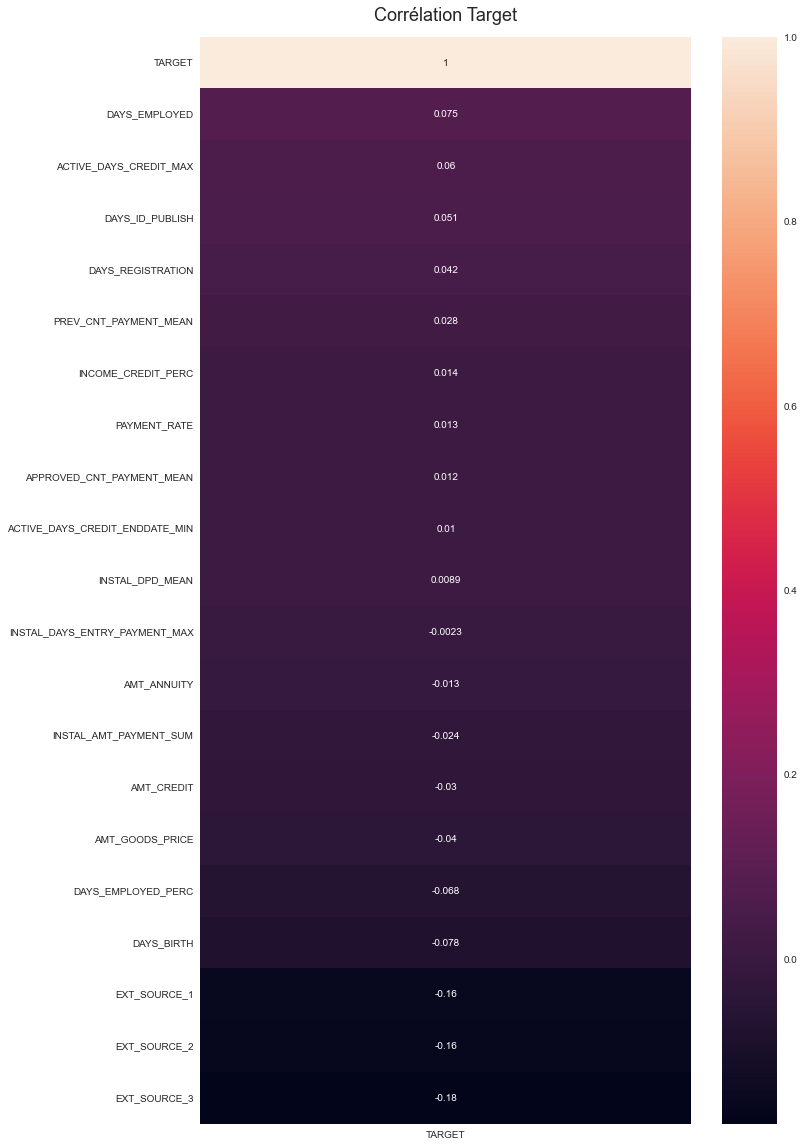

In [34]:
correlation_independante_et_dependante(data_features_train, "TARGET", "Corrélation Target")

# Imputation des valeurs nulles

<AxesSubplot:>

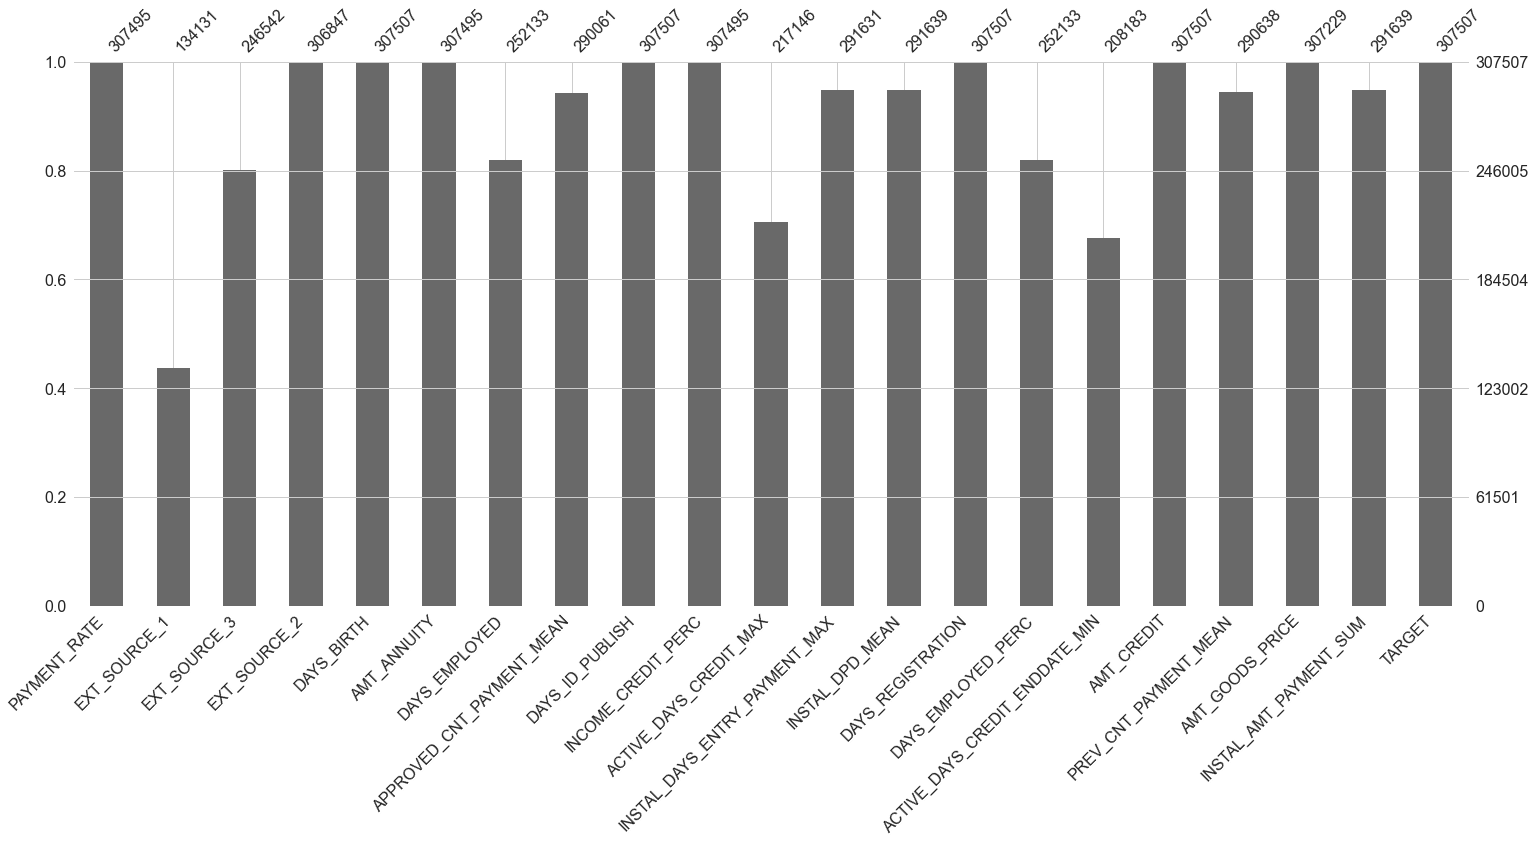

In [35]:
missingno.bar(data_features_train)

In [36]:
auc_smoke(data_features_train, clf)

Cross val score (avg) : 0.7100159704564052


In [37]:
auc_smoke_split(data_features_train, clf)

Cross val score (avg) : 0.7060410757501888



 PREDICTING TARGET CLASS [train data]  :  [0. 1.]

 PREDICTING TARGET CLASS [test data ]  :  [0. 1.]


 1. ACCURACY SCORE [train data]           :  0.9594174286680838
 2. ACCURACY SCORE [test data ]           :  0.8952554388475171
 3. ROC-AUC SCORE  [test data ]           :   0.5481049271322964
 4. ROC-AUC SCORE  [train data ] (predict_proba)          :   0.9906676736322904
 5. ROC-AUC SCORE  [test data ] (predict_proba)          :   0.7086512141128991


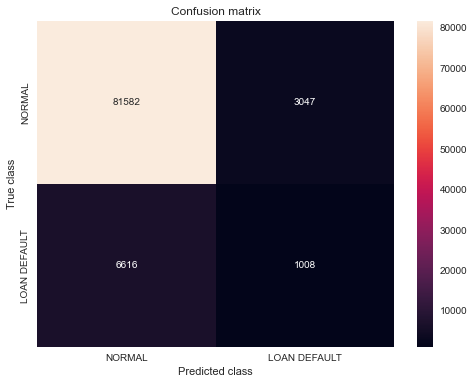


 AUC and ROC curve : 


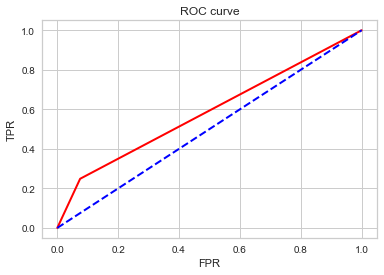

 precision   :  [0.0826423 0.248582  1.       ]
 recall      :  [1.         0.13221406 0.        ]
 thresholds  :  [0. 1.]


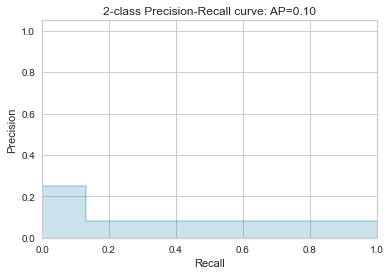

In [38]:
auc_smoke_split_test(data_features_train, clf)


 PREDICTING TARGET CLASS [train data]  :  [0. 1.]

 PREDICTING TARGET CLASS [test data ]  :  [0. 1.]


 1. ACCURACY SCORE [train data]           :  0.9288557429649221
 2. ACCURACY SCORE [test data ]           :  0.8948450121622852
 3. ROC-AUC SCORE  [test data ]           :   0.5470750642672348
 4. ROC-AUC SCORE  [train data ] (predict_proba)          :   0.8934816284299565
 5. ROC-AUC SCORE  [test data ] (predict_proba)          :   0.7064645327046297


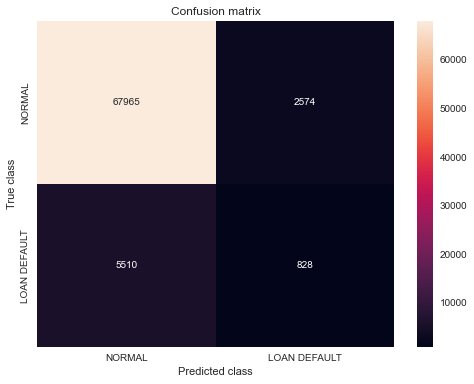


 AUC and ROC curve : 


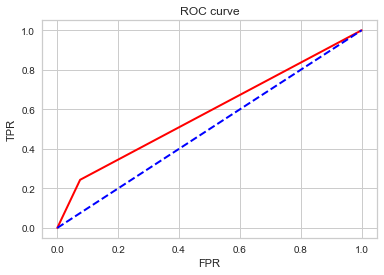

 precision   :  [0.08244338 0.24338624 1.        ]
 recall      :  [1.         0.13064058 0.        ]
 thresholds  :  [0. 1.]


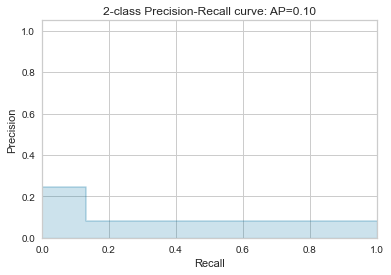

In [39]:
auc_smoke_test(data_features_train, clf)

In [40]:
# explainer = shap.TreeExplainer(clf)
# shap_values = explainer.shap_values(data_features_test[feat])
    
# shap.summary_plot(shap_values, data_features_test[feat], feature_names=feat, max_display=20, show=False)

# plt.savefig('./img/explain_shape.png')
# plt.show()


 PREDICTING TARGET CLASS [train data]  :  [0. 1.]

 PREDICTING TARGET CLASS [test data ]  :  [0. 1.]


 1. ACCURACY SCORE [train data]           :  0.9009409010102762
 2. ACCURACY SCORE [test data ]           :  0.8264240279927677
 3. ROC-AUC SCORE  [test data ]           :   0.6624790592659457
 4. ROC-AUC SCORE  [train data ] (predict_proba)          :   0.9816828600566957
 5. ROC-AUC SCORE  [test data ] (predict_proba)          :   0.7541123079538863


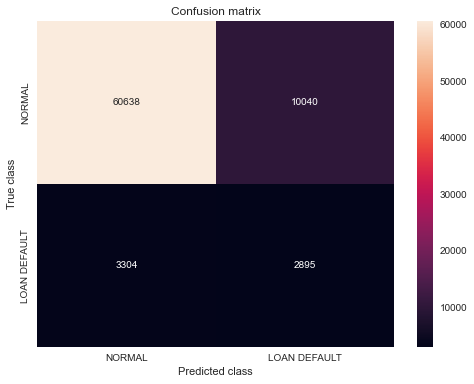


 AUC and ROC curve : 


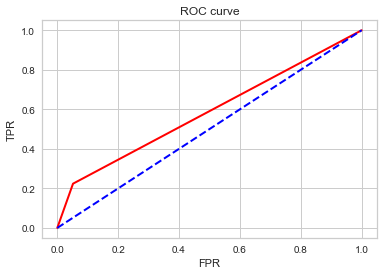

 precision   :  [0.0806353  0.22381136 1.        ]
 recall      :  [1.         0.46701081 0.        ]
 thresholds  :  [0. 1.]


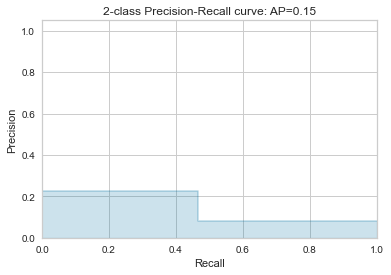

In [41]:
auc_smoke_test_with_balanced(data_features_train, clf_balanced)

## Avec IterativeImputer

In [42]:
clf, train_df, test_df, feat = lightbgm(data_features_train, data_features_test, 2)

[200]	training's auc: 0.784843	training's binary_logloss: 0.238781	valid_1's auc: 0.761173	valid_1's binary_logloss: 0.245893
[400]	training's auc: 0.805213	training's binary_logloss: 0.231136	valid_1's auc: 0.766757	valid_1's binary_logloss: 0.243813
[600]	training's auc: 0.818127	training's binary_logloss: 0.226436	valid_1's auc: 0.767649	valid_1's binary_logloss: 0.243495
[800]	training's auc: 0.829526	training's binary_logloss: 0.222269	valid_1's auc: 0.768096	valid_1's binary_logloss: 0.243378
[200]	training's auc: 0.786901	training's binary_logloss: 0.238111	valid_1's auc: 0.758586	valid_1's binary_logloss: 0.246294
[400]	training's auc: 0.805918	training's binary_logloss: 0.23079	valid_1's auc: 0.764863	valid_1's binary_logloss: 0.24418
[600]	training's auc: 0.819136	training's binary_logloss: 0.225984	valid_1's auc: 0.766343	valid_1's binary_logloss: 0.243773
[800]	training's auc: 0.829767	training's binary_logloss: 0.222096	valid_1's auc: 0.766945	valid_1's binary_logloss: 0.2

Full AUC score 0.767652

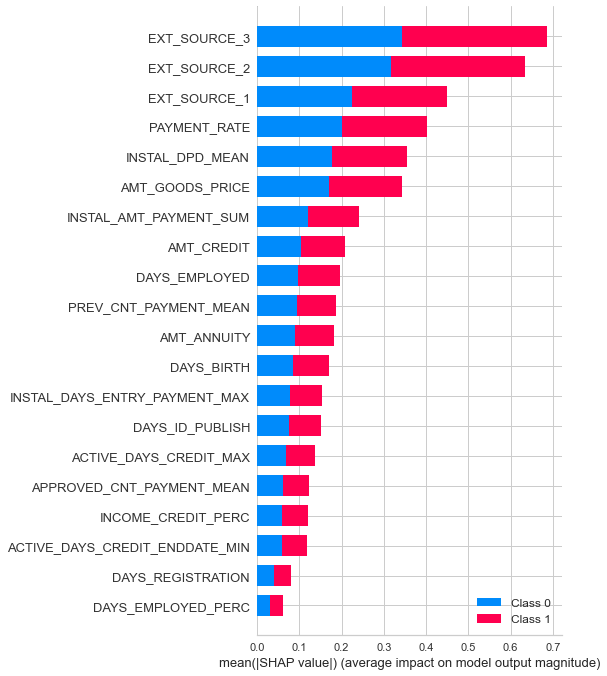

In [43]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(test_df[feat])
    
shap.summary_plot(shap_values, test_df[feat], feature_names=feat, max_display=20, show=False)

plt.savefig('./img/explain_shape.png')
plt.show()

In [44]:
auc_smoke(data_features_train, clf, impute="Iterative")

Cross val score (avg) : 0.7079343401062198


In [45]:
auc_smoke_split(data_features_train, clf, impute="Iterative")

Cross val score (avg) : 0.7040132814092528



 PREDICTING TARGET CLASS [train data]  :  [0. 1.]

 PREDICTING TARGET CLASS [test data ]  :  [0. 1.]


 1. ACCURACY SCORE [train data]           :  0.9578848971754838
 2. ACCURACY SCORE [test data ]           :  0.8906485425948207
 3. ROC-AUC SCORE  [test data ]           :   0.5472065920306592
 4. ROC-AUC SCORE  [train data ] (predict_proba)          :   0.990397278129134
 5. ROC-AUC SCORE  [test data ] (predict_proba)          :   0.7108332269018189


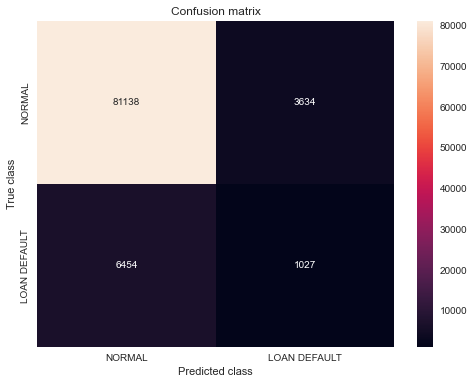


 AUC and ROC curve : 


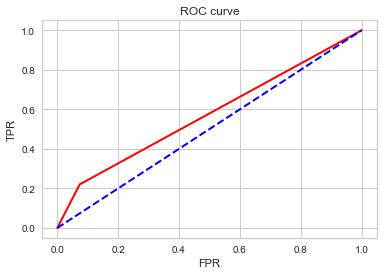

 precision   :  [0.08109221 0.22033898 1.        ]
 recall      :  [1.         0.13728111 0.        ]
 thresholds  :  [0. 1.]


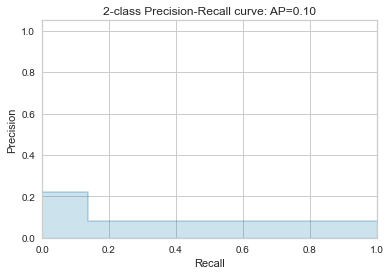

In [46]:
auc_smoke_split_test(data_features_train, clf, impute="Iterative")


 PREDICTING TARGET CLASS [train data]  :  [0. 1.]

 PREDICTING TARGET CLASS [test data ]  :  [0. 1.]


 1. ACCURACY SCORE [train data]           :  0.9251745219615835
 2. ACCURACY SCORE [test data ]           :  0.8916581032038191
 3. ROC-AUC SCORE  [test data ]           :   0.5528251022510263
 4. ROC-AUC SCORE  [train data ] (predict_proba)          :   0.8881408294026459
 5. ROC-AUC SCORE  [test data ] (predict_proba)          :   0.7136466517802995


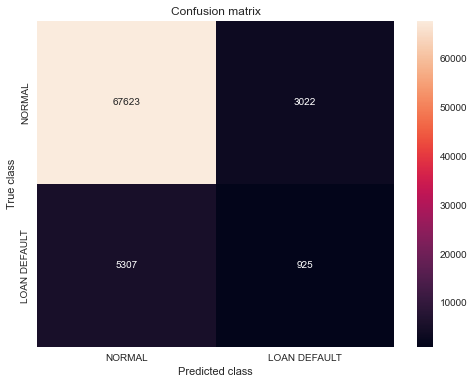


 AUC and ROC curve : 


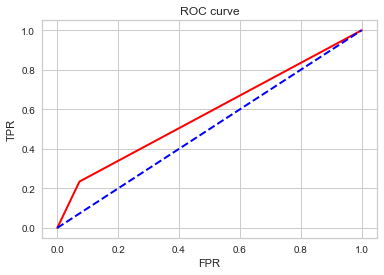

 precision   :  [0.08106456 0.23435521 1.        ]
 recall      :  [1.         0.14842747 0.        ]
 thresholds  :  [0. 1.]


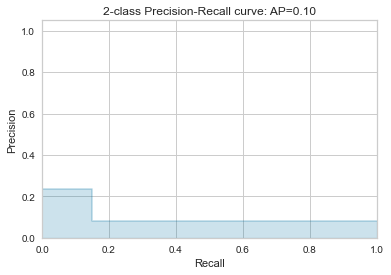

In [47]:
auc_smoke_test(data_features_train, clf, impute="Iterative")


 PREDICTING TARGET CLASS [train data]  :  [0. 1.]

 PREDICTING TARGET CLASS [test data ]  :  [0. 1.]


 1. ACCURACY SCORE [train data]           :  0.9061310323895417
 2. ACCURACY SCORE [test data ]           :  0.8284272279095178
 3. ROC-AUC SCORE  [test data ]           :   0.6573478217403835
 4. ROC-AUC SCORE  [train data ] (predict_proba)          :   0.9846875787781342
 5. ROC-AUC SCORE  [test data ] (predict_proba)          :   0.7528194635180949


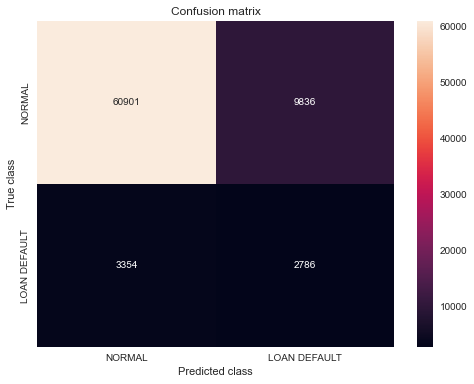


 AUC and ROC curve : 


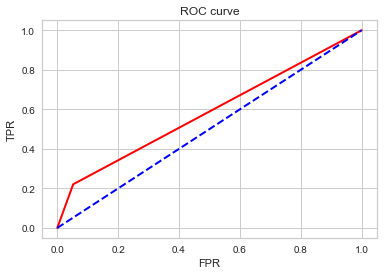

 precision   :  [0.07986784 0.22072572 1.        ]
 recall      :  [1.         0.45374593 0.        ]
 thresholds  :  [0. 1.]


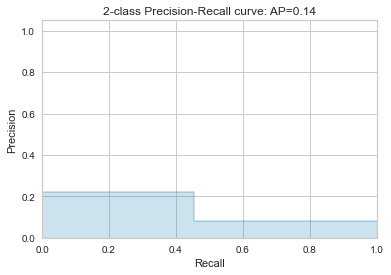

In [48]:
auc_smoke_test_with_balanced(data_features_train, clf_balanced, impute="Iterative")

In [49]:
param_grid = {
    'num_leaves': [120, 127],
    'reg_alpha': [0.3, 0.5]}


grid_imb = auc_smoke_best_params(data_features_train, clf, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.7039660229449962
{'lgbmclassifier__num_leaves': 120, 'lgbmclassifier__reg_alpha': 0.5}
0.709011376096407


In [50]:
sub_preds = np.zeros(data_features_test.shape[0])

sub_preds = grid_imb.predict_proba(data_features_test[feat])[:, 1] # Retourne la probabilité prédite pour chaque classe pour chaque échantillon. # Pourquoi diviser ?
                
data_features_test['TARGET'] = sub_preds

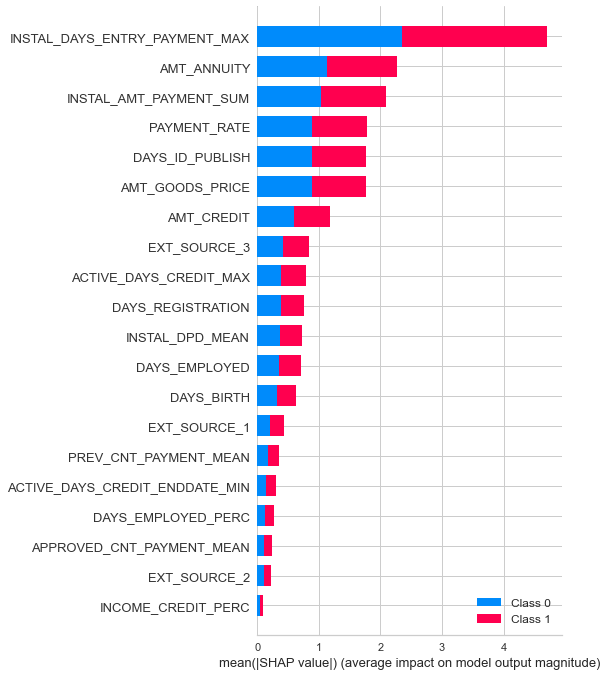

In [55]:
#data_features_test

explainer = shap.TreeExplainer(grid_imb.best_estimator_[3])
shap_values = explainer.shap_values(data_features_test[feat])
    
shap.summary_plot(shap_values, data_features_test[feat], feature_names=feat, max_display=20, show=False)

plt.savefig('./img/explain_shape.png')
plt.show()

# test

In [ ]:
auc_smoke_best_params_imp(data_features_train, clf, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
grid_balanced = auc_smoke_best_params_balanced(data_features_train, clf_balanced, param_grid)

T# est smoke avant

https://www.kaggle.com/code/deepak2873/credit-bureau-imbalance-classification?scriptVersionId=5253968&cellId=140

In [ ]:
auc_smoke_split_smoke_entire(data_features_train, clf)

In [ ]:
auc_smoke_split_smoke_entire(data_features_train, clf, impute="Iterative")

# Test de plusieurs modèles

Le modèle IterativeImputer semble bien meilleur. On va juste tester avec Pycaret pour voir si d'autres modèles peuvent avoir un meilleur résultat.

## Simp

In [ ]:
imp = SimpleImputer(missing_values = np.nan, strategy="median")

nb_row = data_features_train.shape[0] * 0.75

train = data_features_train.iloc[:nb_row]
test = data_features_train.iloc[nb_row:]
    
columns = train.columns
    
train = pd.DataFrame(imp.fit_transform(train[columns]))
    
test = pd.DataFrame(imp.transform(test[columns]))

In [ ]:
test = setup(train, test_data=test, target="TARGET", use_gpu=True, memory="D:/Pycaret/", session_id=0, imputation_type=None, fix_imbalance=True)
best = compare_models(sort="AUC", include=['lightgbm', 'catboost', 'xgboost', 'lda'], turbo=False) 

## Iterative

In [ ]:
imp = IterativeImputer(missing_values = np.nan, random_state=0)

nb_row = data_features_train.shape[0] * 0.75

train = data_features_train.iloc[:nb_row]
test = data_features_train.iloc[nb_row:]
    
columns = train.columns
    
train = pd.DataFrame(imp.fit_transform(train[columns]))
    
test = pd.DataFrame(imp.transform(test[columns]))

In [ ]:
test = setup(train, test_data=test, target="TARGET", use_gpu=True, memory="D:/Pycaret/", session_id=0, imputation_type=None, fix_imbalance=True)
best = compare_models(sort="AUC", include=['lightgbm', 'catboost', 'xgboost', 'lda'], turbo=False) 